In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import math
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from Scattering_Simulator import Read_PDB
from scipy import integrate
import plotly.express as px
from genetic_algorithm import GA_functions as GA
from genetic_algorithm import curve_fitting as cf

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This notebook contains all the code used to fit the experimental data of RhuA Sheets with the model. 

## Load the Coordinates of the Building Block (RhuA)
First, the coodinates of the building block must be loaded. This is simply the coordinates and the scattering length densities of all the atoms in the RhuA PDB file. We will need to orient the protein in the correct orientation to construct the sheets, so the following functions will help us do that. 

In [2]:
def relative_coordinates(volume):
    # Determine the points relative to (0,0)
    rel_x = volume[:,0] - np.mean(volume[:,0])
    rel_y = volume[:,1] - np.mean(volume[:,1])
    rel_z = volume[:,2] - np.mean(volume[:,2])
    relative_volume = np.hstack((rel_x.reshape(-1,1), rel_y.reshape(-1,1), rel_z.reshape(-1,1), volume[:,-1].reshape(-1,1)))
    return relative_volume

def rotate_coordinates_x(y, z, angle):
    angle = angle*math.pi/180
    y_new = y*np.cos(angle) + z*np.sin(angle)
    z_new = -y*np.sin(angle) + z*np.cos(angle)
    return y_new, z_new


def rotate_coordinates_y(x, z, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new


def rotate_coordinates_z(x, y, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + y*np.sin(angle)
    y_new = -x*np.sin(angle) + y*np.cos(angle)
    return x_new, y_new


Text(0.5, 0.92, 'Top Conformation')

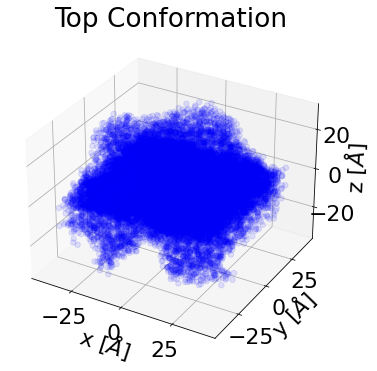

In [3]:
coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1ojr.pdb1') #this function loads the pdb file
coordinates = relative_coordinates(coordinates)
volume = coordinates.copy()
#This rotates the protein around the specifed axis
coordinates[:,1], coordinates[:,2] = rotate_coordinates_x(coordinates[:,1], coordinates[:,2], 180)
coordinates = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates[:,0], coordinates[:,1] = rotate_coordinates_z(coordinates[:,0], coordinates[:,1], 0)
volume_rotated = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates[:,0], coordinates[:,2] = rotate_coordinates_y(coordinates[:,0], coordinates[:,2], -10)
volume_rotated = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates = volume_rotated
# Plotting
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_rotated[:,0],volume_rotated[:,1], color = 'blue', alpha = 0.1, s = 30)
ax.scatter(volume_rotated[:,0],volume_rotated[:,1],volume_rotated[:,2], color = 'blue', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Top Conformation')

Text(0.5, 1.0, 'Other Side view')

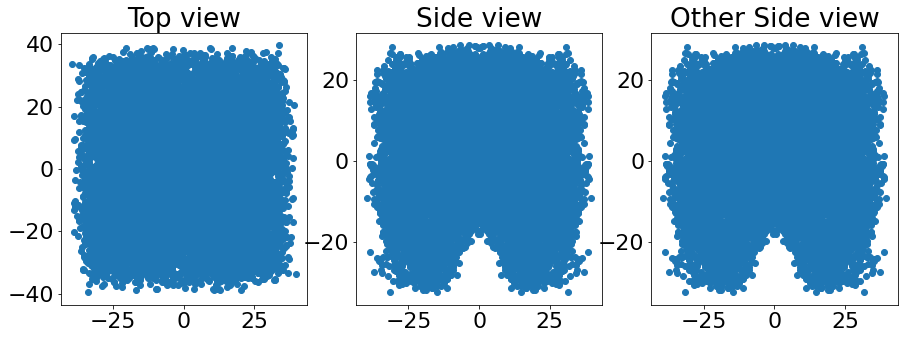

In [4]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3, nrows=1)
ax[0].scatter(volume_rotated[:,0],volume_rotated[:,1])
ax[1].scatter(volume_rotated[:,1],volume_rotated[:,2])
ax[2].scatter(volume_rotated[:,0],volume_rotated[:,2])
ax[0].set_title('Top view')
ax[1].set_title('Side view')
ax[2].set_title('Other Side view')

Now that the protein is orientated correctly, we can write the funcitons used to fit the experimental data to the model

In [8]:
def set_limits(parameters):
    '''This function converts the input parameters which range from 0 to 1 into the correct values
    used to create the sheet model. This is because the inputs and outputs of the genetic algoritm range from 0 to 1.
    inputs:
    - parameters: a 1D array of length 7
    outputs:
    - d: separation distance between the proteins 
    - length: length of the sheet 
    - width: width of the sheet 
    - height: height of the sheet
    - distortion: random distortion of the protein in the height of the sheet 
    - monomer_proportion: proportion of unassembled monomers in the solution 
    - scale: arbitraty parameter used to scale the intensity curve 
    '''
    upper = 85
    lower = 75
    d = int(np.round(parameters[0]*(upper - lower) + lower)) #d
    upper = 25
    lower = 5
    length = int(np.round(parameters[1]*(upper - lower) + lower)) #length 
    upper = 25
    lower = 5
    width = int(np.round(parameters[2]*(upper - lower) + lower)) #Width 
    upper = 5
    lower = 1
    height = int(np.round(parameters[3]*(upper - lower) + lower)) #height
    upper = 2
    lower = 0
    distortion = parameters[4]*(upper - lower) + lower #distortion
    upper = 5
    lower = 0.0
    monomer_proportion = parameters[5]*(upper - lower) + lower #Monomer Proportion
    upper = 1.5
    lower = 0.0
    scale = parameters[6]*(upper - lower) + lower #Scale

    return d, length, width, height, distortion, monomer_proportion, scale


def objective_function(d, length, height, width, distortion, monomer_proportion, scale):
    '''This function creates the sheet model using the specified parameters and simulates its scattering curve
    Inputs:
    - d: separation distance between the proteins 
    - length: length of the sheet 
    - width: width of the sheet 
    - height: height of the sheet
    - distortion: random distortion of the protein in the height of the sheet 
    - monomer_proportion: proportion of unassembled monomers in the solution 
    - scale: arbitraty parameter used to scale the intensity curve 
    Outputs:
    - A 2D array with q and scattering intensity of the specified model 
    '''
    x = np.arange(1, d*length, d)
    y = np.arange(1, d*width,  d)
    z = np.arange(1, d*height, d)

    xx, yy, zz = np.meshgrid(x,y,z)
    xx = xx.flatten().reshape(-1,1)
    yy = yy.flatten().reshape(-1,1)
    zz = zz.flatten().reshape(-1,1)
    lattice_coords = np.hstack((xx, yy, zz))

    random_displacement = np.random.randn(len(lattice_coords), 3)*(distortion*70) 
    random_displacement[:,0] = np.array(len(lattice_coords)*[0])
    random_displacement[:,1] = np.array(len(lattice_coords)*[0])
    lattice_coords = lattice_coords + random_displacement

    all_rotations = np.array([180, 0]*2000)
    rotation_angle_x = all_rotations[0:len(lattice_coords)]
    rotation_angle_y = np.array([0]*len(lattice_coords))
    rotation_angle_z = np.array([0]*len(lattice_coords))
    lattice_coords = np.hstack((lattice_coords, rotation_angle_x.reshape(-1,1), rotation_angle_y.reshape(-1,1), rotation_angle_z.reshape(-1,1)))

    n_samples = 10000000
    simulator = pairwise_method.scattering_simulator(n_samples)
    simulator.sample_building_block(coordinates)
    simulator.sample_lattice_coordinates(lattice_coords)
    simulator.calculate_structure_coordinates()

    histogram_bins = 10000
    q = np.geomspace(0.004, 0.2, 200)
    I_q = simulator.simulate_scattering_curve_fast_lattice(coordinates, lattice_coords, histogram_bins, q, save=True)
    I_q_RhuA = np.load('../Data/simulated_scattering/RhuA/ARhuA_Monomer.npy')[:,-1]
    I_q = (I_q*1e5 + I_q_RhuA*3e2*monomer_proportion)*scale
    return np.hstack((q.reshape(-1,1), I_q.reshape(-1,1)))


def objective_function_multiple(d, length, height, width, distortion, monomer_proportion, scale):
    '''This function creates the sheet model using the specified parameters and simulates its scattering curve
    It is similar to the above function (objective_function), but the output scattering curve is simulated 10 times
    for better accuracy. 
    Inputs:
    - d: separation distance between the proteins 
    - length: length of the sheet 
    - width: width of the sheet 
    - height: height of the sheet
    - distortion: random distortion of the protein in the height of the sheet 
    - monomer_proportion: proportion of unassembled monomers in the solution 
    - scale: arbitraty parameter used to scale the intensity curve 
    Outputs:
    - A 2D array with q and scattering intensity of the specified model 
    '''
    x = np.arange(1, d*length, d)
    y = np.arange(1, d*width,  d)
    z = np.arange(1, d*height, d)

    xx, yy, zz = np.meshgrid(x,y,z)
    xx = xx.flatten().reshape(-1,1)
    yy = yy.flatten().reshape(-1,1)
    zz = zz.flatten().reshape(-1,1)
    lattice_coords = np.hstack((xx, yy, zz))

    random_displacement = np.random.randn(len(lattice_coords), 3)*(distortion*70) 
    random_displacement[:,0] = np.array(len(lattice_coords)*[0])
    random_displacement[:,1] = np.array(len(lattice_coords)*[0])
    lattice_coords = lattice_coords + random_displacement

    all_rotations = np.array([180, 0]*2000)
    rotation_angle_x = all_rotations[0:len(lattice_coords)]
    rotation_angle_y = np.array([0]*len(lattice_coords))
    rotation_angle_z = np.array([0]*len(lattice_coords))
    lattice_coords = np.hstack((lattice_coords, rotation_angle_x.reshape(-1,1), rotation_angle_y.reshape(-1,1), rotation_angle_z.reshape(-1,1)))

    n_samples = 10000000
    simulator = pairwise_method.scattering_simulator(n_samples)
    simulator.sample_building_block(coordinates)
    simulator.sample_lattice_coordinates(lattice_coords)
    simulator.calculate_structure_coordinates()

    histogram_bins = 10000
    q = np.geomspace(0.004, 0.2, 200)
    I_q = simulator.simulate_multiple_scattering_curves_lattice_coords(coordinates, lattice_coords, histogram_bins, q, save=True)
    I_q_RhuA = np.load('../Data/simulated_scattering/RhuA/ARhuA_Monomer.npy')[:,-1]
    I_q = (I_q*1e5 + I_q_RhuA.reshape(-1,1)*3e2*monomer_proportion)*scale
    return np.hstack((q.reshape(-1,1), I_q))


def convert_data(data, model):
    '''This function bins the model data so that it has the same number of data points as the experimental data
    inputs:
    - data: the experimental data with q and intensity as the two colums in the 2D array
    - model: the simulated data with q and intensity as the two columns in the 2D array
    output:
    - new_model_data: the binned model data with q and I as the two columns in the 2D array'''
    model_x = model[:,0]
    model_y = model[:,1]
    index = np.linspace(0, len(model_x)-1, len(model_x)) 
    model_q_new = []
    model_I_new = []
    for i in range(len(data)):
        data_q = data[i,0]
        array = np.abs(model_x - data_q)
        array = np.hstack((array.reshape(-1,1), index.reshape(-1,1)))
        array = array[np.argsort(array[:, 0])]
        loc = int(array[0,1])
        model_q_new.append(model_x[loc])
        model_I_new.append(model_y[loc])
    q = np.array(model_q_new).reshape(-1,1)
    I = np.array(model_I_new).reshape(-1,1)
    new_model_data = np.hstack((q, I))
    return new_model_data


def evaluate_obj_func(parameters, exp_data):
    '''This function evaluates the objective function and obtains a score for each set of input parameters
    inputs:
    - parameters: a 1D array of length 7 with each value corresponding to a structural parameter of the sheet model. These values range
    from 0 to 1 and are obtain from the genetic algorithm
    exp_data: the experimental data of the sheet structure
    outputs:
    - error: The score between the scattering curve of the model and the experimental data'''
    d, length, width, height, distortion, monomer_proportion, scale = set_limits(parameters)
    sim_data = objective_function(d, length, width, height, distortion, monomer_proportion, scale)
    sim_data = convert_data(exp_data, sim_data)
    plt.rcParams.update({'font.size': 22})
    #fig, ax = plt.subplots(figsize=(7,7))
    plt.ylabel('Intensity (arb. unit)')
    plt.xlabel('q ($\AA^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(sim_data[:,0], sim_data[:,1])
    plt.plot(exp_data[:,0], exp_data[:,1], linewidth=3, color ='k')
    error = np.mean(np.abs(np.log10(np.abs(exp_data[:,1])) - np.log10(np.abs(sim_data[:,1]))))
    return -error

def evaluate_obj_func_loop(x, exp_data):
    '''This function evaluates the objective function in a loop and obtains a score for each set of input parameters
    inputs:
    - x: a 2D array of columns 7 and as many rows with each column corresponding to a structural parameter of the sheet model. Each row represents
    a different candidate. All values range from 0 to 1 and are obtain from the genetic algorithm
    outputs:
    - y: an array of scores between the scattering curve of the model and the experimental data'''
    for i in range(x.shape[0]): # This is a loop that runs the test function for each row of an array
        y_row = evaluate_obj_func(x[i,:], exp_data)
        if i == 0:
            y = y_row
        else:
            y = np.vstack((y, y_row))
    return y

def run_optimization(exp_data, batch_size, mutation_rate, iterations):
    '''This function runs the genetic optimizer
    inputs:
    - exp_data: experimental data of the sample
    - batch_size: number of samples in each iteration
    - mutation_rate: controls exploration vs exploitation of the GA
    - iterations: number of iterations to run
    outputs:
    - alg.best_solution(): the best solution found in the optimization 
    - alg.max_fitness_lst: the history of the best scores at each iteration 
    '''
    x = np.random.rand(batch_size, 7)
    y = evaluate_obj_func_loop(x, exp_data)
    alg = GA.genetic_algorithm(batch_size, mutation_rate)
    for i in range(iterations):
        x = alg.run(x,y)
        y = evaluate_obj_func_loop(x, exp_data)
    return alg.best_solution(), alg.max_fitness_lst

## Simulate the Scattering Curve
The experimental data is first imported and plotted. 

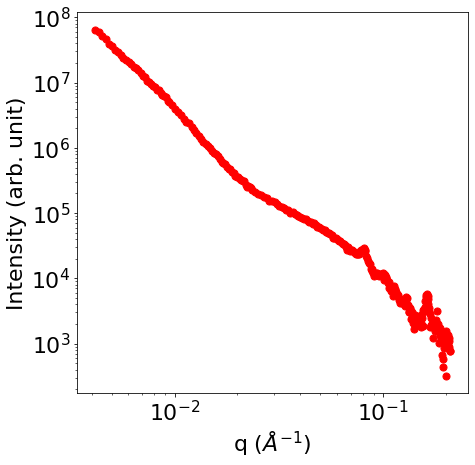

In [9]:
exp_data = np.load('../Data/RhuA/CaCl2_merged.npy')

fig, ax = plt.subplots(figsize=(7,7))

plt.scatter(exp_data[:,0], exp_data[:,1]*4e6, s=50, label = 'Exp Data', color = 'red')

plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('../Images/RhuA/Sheets_Exp_data.png', dpi=600, bbox_inches="tight")

This line of code will run the optimization. The parameters of the optimization can be modified. 

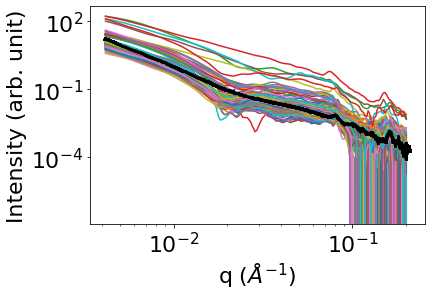

In [36]:
batch_size = 10
mutation_rate = 0.15
iterations = 10
best_solution, max_fitness_lst = run_optimization(exp_data, batch_size, mutation_rate, iterations)

This shows how score of the best sample of each batch changes over the iterations. Scores closer to 0 are nearer the target.  

Text(0, 0.5, 'Score')

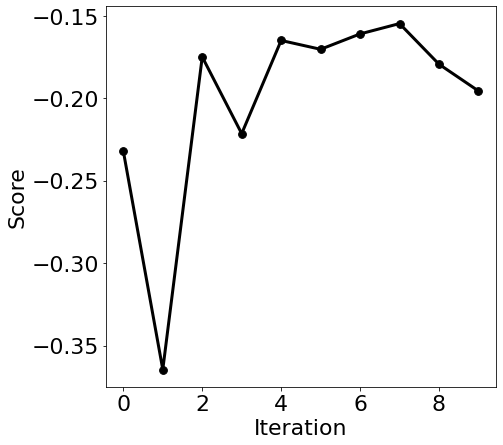

In [37]:
fig, ax = plt.subplots(figsize=(7,7))
itr = np.arange(0,iterations)
plt.plot(itr, max_fitness_lst, linewidth = 3, color='k')
plt.scatter(itr, max_fitness_lst, s = 60, color ='k')
plt.xlabel('Iteration')
plt.ylabel('Score')
#plt.savefig('../Images/RhuA/Sheets_Score.png', dpi=600, bbox_inches="tight")

The best parameters obtained from the optimization are shown. 

In [38]:
values = set_limits(best_solution)
print('d: ',values[0])
print('length: ',values[1])
print('width: ',values[2])
print('height: ',values[3])
print('distortion: ',values[4])
print('monomer_proportion: ', values[5])
print('Scale: ', values[6])

d:  77
length:  19
width:  18
height:  4
distortion:  1.452
monomer_proportion:  2.63
Scale:  0.14700000000000002


The scattering curve of the best sample is then re-simulated to compare it with the experimental data. It will be simulated 10 times to reduce the random errors in the simulation

In [39]:
#best_fit = objective_function(values[0], values[1], values[2], values[3], values[4], values[5], values[6])
best_fit = objective_function_multiple(values[0], values[1], values[2], values[3], values[4], values[5], values[6])
best_fit_mean = np.mean(best_fit[:,1:], axis=1)

A second curve can also be simulated to compare it with the best sample. 

In [40]:
d = 83
length =  5
width = 13
height = 4
distortion = .82 #5
monomer_proportion = 0.445 #.444
scale = 0.70
simulated_data = objective_function_multiple(d, length, width, height, distortion, monomer_proportion, scale)
simulated_data = np.mean(simulated_data[:,1:], axis=1)


## Plot the Results

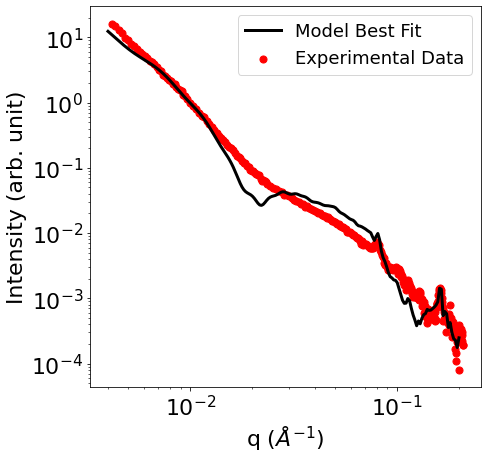

In [42]:
I_q_RhuA = np.load('../Data/simulated_scattering/RhuA/ARhuA_Monomer.npy')[:,-1]

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))

plt.scatter(exp_data[:,0], exp_data[:,1], s=50, label = 'Experimental Data', color = 'red')
plt.plot(best_fit[:,0], best_fit_mean, color = 'k', linewidth=3, label = 'Model Best Fit')
#plt.plot(best_fit[:,0], simulated_data, color='blue', linewidth=3, label = 'Model')

plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1, fontsize=18)
#plt.savefig('../Images/RhuA/Comparison_Sheets_Model.png', dpi=600, bbox_inches="tight")

In [16]:
# best_fit_2 = np.hstack((best_fit[:,0].reshape(-1,1), best_fit_mean.reshape(-1,1)*0.9))
# np.save('../Images/RhuA/Sheets_Best_fit.npy', best_fit_2)
# np.save('../Images/RhuA/Sheets_Max_fitness_lst.npy', max_fitness_lst)
# np.save('../Images/RhuA/Sheets_best_solution_lst.npy', best_solution_lst)

In [41]:
# I_q_RhuA = np.load('../Data/simulated_scattering/RhuA/ARhuA_Monomer.npy')[:,-1]

# plt.rcParams.update({'font.size': 22})
# fig, ax = plt.subplots(figsize=(7,7))


# for i in range(10):
#     values = set_limits(np.random.rand(1, 7).flatten())
#     best_fit = objective_function(values[0], values[1], values[2], values[3], values[4], values[5], values[6])
#     plt.plot(best_fit[:,0], best_fit[:,1], linewidth=3, alpha=0.7)

# plt.plot(exp_data[:,0], exp_data[:,1], linewidth=6, label = 'Experimental Data', color = 'red')
# plt.ylabel('Intensity (arb. unit)')
# plt.xlabel('q ($\AA^{-1}$)')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend(loc=1, fontsize=18)
# #plt.savefig('../Images/RhuA/Comparison_Sheets_Model_and_Experiment.png', dpi=300, bbox_inches="tight")